In [ ]:
!pip install tensorflow==2.4.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 394.3 MB 16 kB/s 
     |████████████████████████████████| 132 kB 84.6 MB/s 
     |████████████████████████████████| 462 kB 96.0 MB/s 
     |████████████████████████████████| 14.8 MB 51.8 MB/s 
     |████████████████████████████████| 2.9 MB 51.6 MB/s 
     |████████████████████████████████| 3.8 MB 57.9 MB/s 
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68721 sha256=0fa19165a3056ed9b4abbcbe80e7caeab404c534bd96e9a538d83b4f6e0efa83
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.1.1
    Uninstalling typing-extensions-4.1.1:
      Successfully uninstalled typing-extensions-4.1.1
  Attempting uninstall: numpy
    Found existing installation: n

In [3]:
import tensorflow as tf
print(tf.__version__)
import helper_functions as hf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd
from tensorflow.keras.utils import plot_model

2.4.1


In [4]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

## 2022.07.01 - Food Vision 1

### GPU for Mixed Precision training
- save memory and computing resource usage to speed up the training process
  - https://www.tensorflow.org/guide/mixed_precision
- benefit when the type of GPU is 7.0+ like 
  - Tesla T4(compatible)

In [5]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-07-02 09:10:32--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-07-02 09:10:32 (93.6 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# copy the model
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip
hf.unzip_data("07_efficientnetb0_feature_extract_model_mixed_precision.zip")

--2022-07-02 09:20:54--  https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.128.128, 173.194.69.128, 173.194.79.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.128.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16976857 (16M) [application/zip]
Saving to: ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip.1’

07_efficientnetb0_f 100%[===================>]  16.19M  51.9MB/s    in 0.3s    

2022-07-02 09:20:55 (51.9 MB/s) - ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip.1’ saved [16976857/16976857]



### Tensorflow Dataset

In [ ]:
catalog = tfds.list_builders()
print(len(catalog))
"food101" in catalog 

224


True

In [ ]:
# it has cache mechanism so if we download it first time, once we re-download, it will get the file from the cache.
(train_data,test_data),ds_info = tfds.load(name = "food101",
                                           split = ["train","validation"],
                                           as_supervised = True,# the train/validatioon data will in the (data,label) format
                                           shuffle_files = True,
                                           with_info = True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteARDSQ2/food101-train.tfrecord


  0%|          | 0/75750 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteARDSQ2/food101-validation.tfrecord


  0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [ ]:
class_names = ds_info.features["label"].names
class_names[:10]
one_image_sample = train_data.take(1)

(512, 512, 3)
<dtype: 'uint8'>
tf.Tensor(90, shape=(), dtype=int64)
spaghetti_bolognese


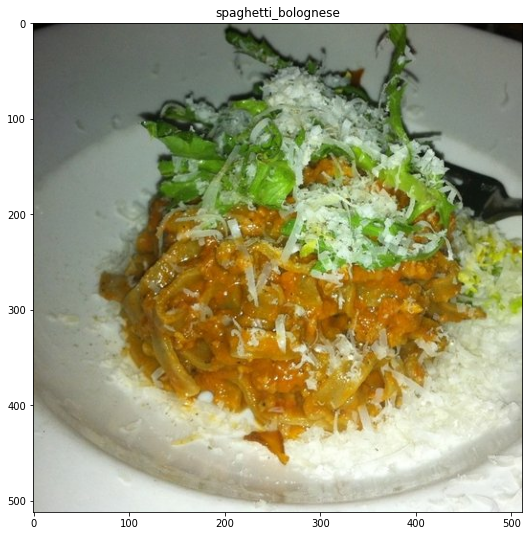

In [ ]:
for image,label in one_image_sample:
  print(image.shape)
  print(image.dtype)
  print(label) # not one-hot-encoding, is a label encoding
  print(class_names[label.numpy()])
plt.figure(figsize=(12,9))
plt.title(class_names[label.numpy()])
plt.imshow(image)

### Preprocessing the Image
- cast from int to float32 to take the advantages of mixed precision training
- reshape to unified image shape
- resize for normalization (if necessary, depends on the pre-trained model)
- batches with the same batch

In [ ]:
def preprocess_image(image,label,img_shape=224):
  img = tf.image.resize(image,size = [img_shape,img_shape])
  return tf.cast(img,tf.float32),label
preprocess_image(image,label)

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[1.1586735e+01, 1.2586735e+01, 6.5867348e+00],
         [1.1714286e+01, 1.2714286e+01, 6.7142859e+00],
         [8.8571424e+00, 9.8571424e+00, 4.8571424e+00],
         ...,
         [2.0714308e+01, 1.1142836e+01, 1.2857144e+00],
         [2.0668371e+01, 1.0668372e+01, 0.0000000e+00],
         [2.1000000e+01, 1.1000000e+01, 0.0000000e+00]],
 
        [[2.3571415e+00, 3.3571415e+00, 1.4285660e-01],
         [3.1530607e+00, 4.1530609e+00, 7.6530278e-02],
         [3.0561223e+00, 4.0561223e+00, 0.0000000e+00],
         ...,
         [2.6071407e+01, 1.8071407e+01, 7.0714073e+00],
         [2.4785702e+01, 1.4785702e+01, 4.7857018e+00],
         [2.2499966e+01, 1.2499966e+01, 2.4999657e+00]],
 
        [[1.3520410e+00, 2.3520410e+00, 0.0000000e+00],
         [3.0408173e+00, 4.0408173e+00, 6.1224538e-01],
         [7.2346954e+00, 8.1887770e+00, 3.3265321e+00],
         ...,
         [2.5479622e+01, 1.7382635e+01, 8.3826580e+00],


### Batching and Preparing Data
- Build Data Input Pipeline:
  - like "Feature Engineering pipeline"
  - https://www.tensorflow.org/guide/data
  - https://www.tensorflow.org/guide/data_performance#best_practice_summary

In [ ]:
train_dataset = train_data.map(map_func = preprocess_image,num_parallel_calls=tf.data.AUTOTUNE)

# shuffle amount can be determined by your memory liimit
# cache(). load the all data into the memory but need to make sure you have enough memory
# batch(batch_size)
# prefetch: speed up the data loading.
## CPU will prefetch 1 batch to memory for the next round iteration during the training. once go to next round then will move the prefetch dataset to GPU and so o.
# tf.data.AUTOUNE => consume available coomputing resource
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(32).prefetch(buffer_size = tf.data.AUTOTUNE)


# map no need to shuffle
test_dataset = test_data.map(map_func=preprocess_image,num_parallel_calls=tf.data.AUTOTUNE)\
                        .batch(32)\
                        .prefetch(buffer_size = tf.data.AUTOTUNE)

In [ ]:
train_dataset,test_dataset

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

### Prefetch
- one way to improve tensorflow model performance

### Callbacks
- ModelCheckpoints Callbacks
- Tensorboard Callbacks

In [ ]:
checkpoint_file_path = "model_checkpoint/ck.ckpt"
modelcheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_file_path,
                                                     monitor="val_accuracy",
                                                     save_weights_only=True,
                                                     save_best_only=True,
                                                     verbose=0)

## 2022.07.02 - Food Vision 2

### Set up Mixed Precision Training
- Computing on float16
  - layer operations
- Variables on float32
- constrast: single-precision floating-point training

In [ ]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('float32')
mixed_precision.global_policy()

<Policy "float32">

In [ ]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = tf.keras.Input(shape=(224,224,3),name="input_layer")
x = base_model(inputs,training = False)
x = tf.keras.layers.GlobalAvgPool2D()(x)

# if we put the activation in the dense layer => the numeric format might be float16
# so in order to keep the numeric stability, need to convert the dtype of output share after activation
x = tf.keras.layers.Dense(len(class_names))(x)
outputs = tf.keras.layers.Activation("softmax",dtype="float32",name="softmax_float32")(x)
model = tf.keras.Model(inputs,outputs)

model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ["accuracy"])

16711680/16705208 [==============================] - 0s 0us/step


NameError: ignored

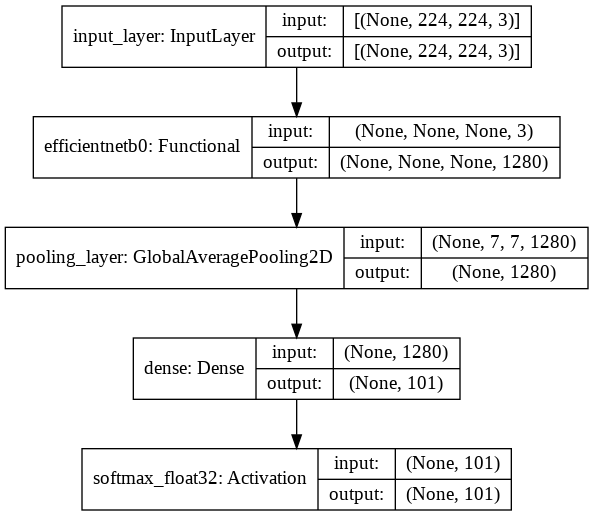

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True)

### Check model layer - Mixed Precision.

In [ ]:
for la in model.layers:
  print(la.name,la.trainable,la.dtype,la.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling2d_1 True float32 <Policy "mixed_float16">
dense_1 True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [ ]:
# the dtype of variables in the layer[3]
model.layers[3].kernel.dtype

tf.float32

In [ ]:
model.layers[1]

In [ ]:
for dla in model.layers[1].layers[:20]:
  print(dla.name,dla.trainable,dla.dtype,dla.dtype_policy)

input_2 False float32 <Policy "float32">
rescaling_1 False float32 <Policy "mixed_float16">
normalization_1 False float32 <Policy "float32">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False float

### Model Training

In [ ]:
model.fit(train_dataset,
          epochs = 3,
          steps_per_epoch = len(train_dataset),
          validation_steps = 0.15 * len(test_dataset),
          validation_data = test_dataset,
          callbacks = [hf.create_tensorboard_callback("training_logs",
                                                      "efficientnetb0_101"),
                       modelcheckpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101/20220702-073740
Epoch 1/3
2368/2368 [==============================] - 273s 105ms/step - loss: 2.3224 - accuracy: 0.4659 - val_loss: 1.2279 - val_accuracy: 0.6765
Epoch 2/3
2368/2368 [==============================] - 246s 103ms/step - loss: 1.3211 - accuracy: 0.6599 - val_loss: 1.1306 - val_accuracy: 0.6964
Epoch 3/3
2368/2368 [==============================] - 246s 102ms/step - loss: 1.1533 - accuracy: 0.6998 - val_loss: 1.0849 - val_accuracy: 0.7080


In [ ]:
model.evaluate(test_dataset)

790/790 [==============================] - 49s 62ms/step - loss: 1.0809 - accuracy: 0.7090


[1.0808913707733154, 0.7090296745300293]

### Exercise
- Visualize
  - Confusion Matrix
  - F1-Score
  - Prediction on the image. and visualize
- Retrain with efficientnetB4

In [6]:
model = tf.keras.models.load_model("07_efficientnetb0_feature_extract_model_mixed_precision")

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [ ]:
len(test_dataset)

790

In [7]:
model.evaluate(test_dataset,verbose = 1)

NameError: ignored

In [ ]:
# visualize the confusion matrix, classification report
pred_probs = model.predict(test_dataset, verbose=1, workers=3)

 22/790 [..............................] - ETA: 25:22:15

In [ ]:
pred_labels = pred_probs.argmax(axis=1)
pred_classes = [class_names[i] for i in pred_labels]

In [ ]:
actual_labels = [la.numpy() for _, la in test_dataset.unbatch().take(-1)]
actual_classes = [class_names[i] for i in actual_labels] 

In [ ]:
np.mean(actual_labels == pred_labels)

[93, 42, 83, 98, 40, 60, 13, 36, 21, 92, 25, 29, 66, 81, 81, 1, 83, 16, 92, 60, 32, 36, 48, 94, 0, 65, 29, 37, 87, 56, 65, 64, 26, 83, 45, 23, 80, 30, 45, 94, 92, 46, 72, 28, 75, 18, 99, 16, 40, 37, 99, 60, 40, 1, 69, 52, 62, 77, 67, 12, 53, 96, 70, 44, 15, 71, 49, 7, 33, 52, 12, 69, 54, 88, 53, 3, 50, 38, 6, 84, 70, 65, 34, 70, 69, 23, 78, 41, 13, 27, 25, 32, 41, 5, 20, 59, 53, 57, 48, 81] [ 29  34  16  48  79  15  81  47   4  57  21  14  27  70  14  90  21  59
  61  55   1  81  76  54  82  15  90   4  15  67  50  19  44  65  34 100
  69  70  23   3  78  64  27  61  59  32  48  20  59  22  49  12   7  53
  33  69  52  95  88  54  80   3  38  84   6  70  44  29  60  80  57  32
   1  40  99   1  71   4  85  44  44  86  79  78  21  40  51  12   5  13
  17  72  98  36  54  53  26  37  35  68]


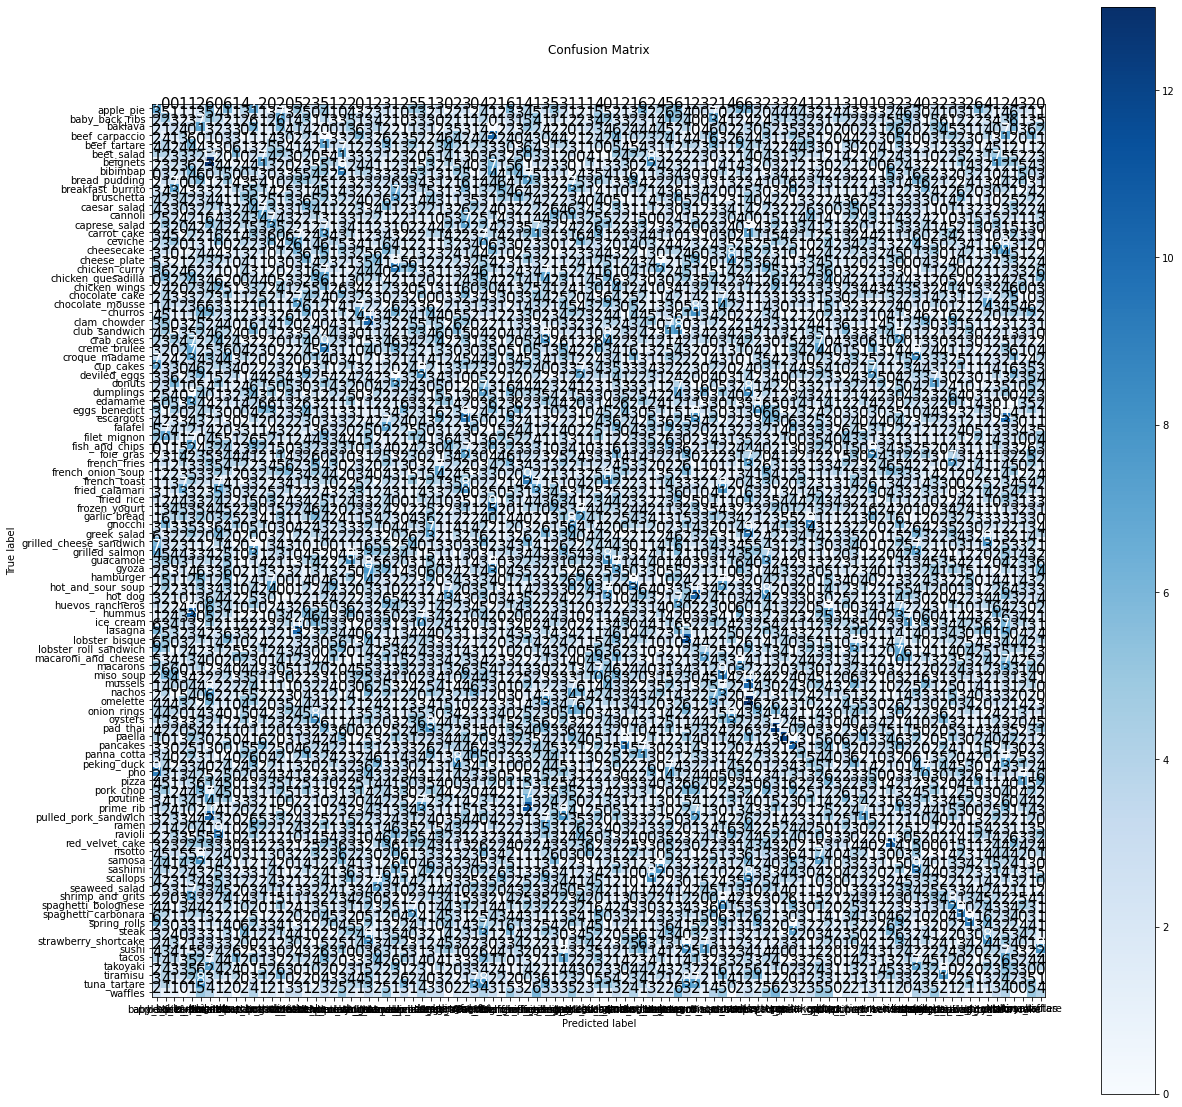

In [ ]:
# confusion_matrixx
hf.make_confusion_matrix(
    y_true=actual_classes,
    y_pred = pred_classes,
    classes=class_names,
    figsize=(50,50),
    savefig=True
  )

In [ ]:
result = classification_report(y_true=actual_labels,y_pred=pred_class,output_dict=True)

In [ ]:
f1_score_dict = dict()
for k,v in result.items():
  if k=="accuracy":
    break
  else:
    f1_score_dict[int(k)] = v["f1-score"]

In [ ]:
import pandas as pd
pred_df = pd.DataFrame({
    "actual_class":[class_names[class_id] for class_id in f1_score_dict.keys()],
    #"pred_class": pred_classes,
    "f1_score":f1_score_dict.values()
}).sort_values("f1_score")

<bound method _AxesBase.invert_yaxis of <matplotlib.axes._subplots.AxesSubplot object at 0x7f00a82536d0>>

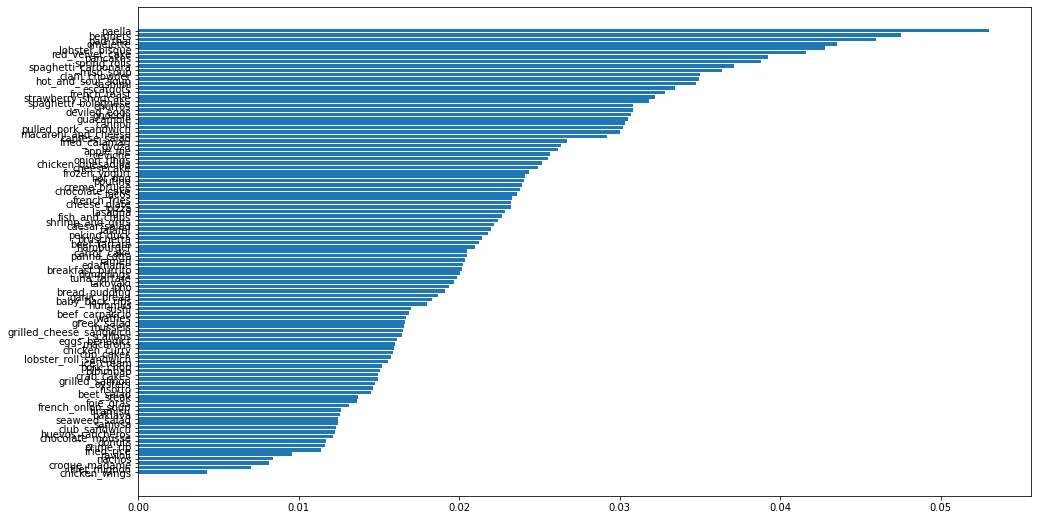

In [ ]:
fig,ax = plt.subplots(figsize=(16,9))
ax.barh(pred_df["actual_class"],pred_df["f1_score"])
ax.invert_yaxis